In [1]:
library(monocle3)
library(Seurat)



Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; vie

In [2]:
extract.neurons <- function(){
    library(DropSeq.util)
    library(Seurat)

    regions = list(
            "Cerebellum_ALT" = c("CB","cerebellum"),
            "EntoPeduncular" = c("ENT","entopeduncular"),
            "Cortex_noRep5_FRONTALonly" = c("FC", "frontal_cortex"),
            "GlobusPallidus" = c("GP","GlobusPallidus"),
            "Hippocampus" = c("HC","Hippocampus"),
            "Cortex_noRep5_POSTERIORonly" = c("PC", "posterior_cortex"),
            "Striatum" = c("STR", "Striatum"),
            "SubstantiaNigra" = c("SN","SubstantiaNigra"), 
            "Thalamus" = c("TH","Thalamus")
    )

    saunders.meta = read.csv('saunders-macosko/annotation.BrainCellAtlas_Saunders_version_2018.04.01.csv')

    sro = NULL

    for (file.prefix in names(regions)){
        print(file.prefix)
        region.id = regions[[file.prefix]][1]
        region.name = regions[[file.prefix]][2]   
        saunders.data <- loadSparseDge(paste0("saunders-macosko/F_GRCm38.81.P60",file.prefix,".raw.dge.txt.gz"))

        clusters = readRDS(paste0("saunders-macosko/F_GRCm38.81.P60",file.prefix,".cell_cluster_outcomes.RDS"))
        subclusters = readRDS(paste0("saunders-macosko/F_GRCm38.81.P60", file.prefix,".subcluster.assign.RDS"))
        neuronal.clusters = subset(saunders.meta, (class == 'NEURON') & (tissue == region.id))
        paste("Region", region.name, "dim", dim(saunders.data))
        sc = unique(neuronal.clusters$subcluster)
        mask = !is.na(clusters$subcluster) & (clusters$subcluster %in% sc)
        saunders.data = saunders.data[,mask]
        cell.meta = clusters[mask,]
        sro.tmp = CreateSeuratObject(saunders.data, project = paste0('saunders_',region.id))
        sro.tmp@meta.data$region = region.id
        sro.tmp@meta.data$cluster = as.factor(cell.meta$cluster)
        sro.tmp@meta.data$subcluster = as.factor(cell.meta$subcluster) 
        if(is.null(sro)){
            sro = sro.tmp
        }else{
            #if(length(sro) == length(sro.tmp) | any(rownames(sro) == rownames(sro.tmp))){
            #    stop(paste0('Oh No', file.prefix,' gene vector mismatch'))
            #}
            sro = merge(sro, sro.tmp)
            message(paste('sro has',length(rownames(sro)),'features'))
            
        }
    }

    saveRDS(sro, 'saunders-neurons.rds')
    sro
}

sro <- extract.neurons()

Loading required package: data.table

Warning message:
"package 'data.table' was built under R version 3.6.2"

Attaching package: 'data.table'


The following object is masked from 'package:SummarizedExperiment':

    shift


The following object is masked from 'package:GenomicRanges':

    shift


The following object is masked from 'package:IRanges':

    shift


The following objects are masked from 'package:S4Vectors':

    first, second


Loading required package: Matrix

Warning message:
"package 'Matrix' was built under R version 3.6.2"

Attaching package: 'Matrix'


The following object is masked from 'package:S4Vectors':

    expand




[1] "Cerebellum_ALT"
[1] "EntoPeduncular"


sro has 25651 features



[1] "Cortex_noRep5_FRONTALonly"


sro has 30079 features



[1] "GlobusPallidus"


sro has 30710 features



[1] "Hippocampus"


sro has 31292 features



[1] "Cortex_noRep5_POSTERIORonly"


sro has 31697 features



[1] "Striatum"


sro has 31832 features



[1] "SubstantiaNigra"


sro has 32057 features



[1] "Thalamus"


sro has 32307 features



[1]  32307 177085

In [4]:
convertHumanGeneList <- function(x){
    require("biomaRt")
    human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
    mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")

    genesV2 = getLDS(attributes = c("hgnc_symbol"), filters = "hgnc_symbol", values = x , mart = human, attributesL = c("mgi_symbol"), martL = mouse, uniqueRows=T)

    humanx <- genesV2
    return(humanx)
}

convertMatrixToHomology <- function(mat){
    
    gene.set = rownames(mat)
    homologues = convertHumanGeneList(gene.set)
    # Exclude gene symbols not available in dataset
    homologues = homologues[homologues$MGI.symbol %in% rownames(mat),]
    
    # Filter non unique genes! Maybe aggregate?
    t.homo = data.frame(table(homologues$HGNC.symbol))
    homo.unique = t.homo[t.homo$Freq == 1,]$Var1
    homologues = homologues[homologues$HGNC.symbol %in% homo.unique,]
    
    # Remove from data genes that are not in the homologue list
    mat.filtered = mat[rownames(mat) %in% homologues$MGI.symbol,]
    # Sort genes according to dataframe
    mat.homology = mat.filtered[homologues$MGI.symbol,]
    
    # replace with human genes
    rownames(mat.homology) = homologues$HGNC.symbol
    mat.homology
}

saunders.human = convertMatrixToHomology(sro@assays$RNA@counts)

sro.human = CreateSeuratObject(saunders.human, project = 'saunders-neurons')
sro.human@meta.data = sro@meta.data
saveRDS(sro.human, 'saunders-with-human-genes.rds')

Loading required package: biomaRt



In [5]:
cds = new_cell_data_set(sro.human@assays$RNA@counts, cell_metadata = sro.human@meta.data)
rowData(cds)$gene_short_name = rownames(cds)
saveRDS(cds, './objects/saunders-homology-object-raw.rds')

Warning message in new_cell_data_set(sro.human@assays$RNA@counts, cell_metadata = sro.human@meta.data):
"Warning: gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions."


In [8]:
colData(cds)

DataFrame with 177085 rows and 7 columns
                          orig.ident nCount_RNA nFeature_RNA      region
                         <character>  <numeric>    <integer> <character>
P60CBRep1P1_GACTCTACACCC P60CBRep1P1      11903         3873          CB
P60CBRep1P1_GTACCTGAGCCT P60CBRep1P1       8849         3637          CB
P60CBRep1P1_GCCCTATCTTGG P60CBRep1P1       7512         3089          CB
P60CBRep1P1_TGAAGATAGGTC P60CBRep1P1       7027         3109          CB
P60CBRep1P1_CAGCCGAAATGG P60CBRep1P1       6843         2959          CB
...                              ...        ...          ...         ...
P60THRep6P2_GGACTGAGAACA P60THRep6P2       1157          883          TH
P60THRep6P2_GAGATCTGCTAA P60THRep6P2       1128          822          TH
P60THRep6P2_TTTTTCGCGAAT P60THRep6P2       1111          810          TH
P60THRep6P2_AGGTGAATTCAT P60THRep6P2       1082          832          TH
P60THRep6P2_GTGTGACTGGTT P60THRep6P2       1074          770          TH
          

Warning message in new_cell_data_set(sro.human@assays$RNA@counts, cell_metadata = sro.human@meta.data):
"Warning: gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions."


In [6]:


#colData(cds.mouse)$Cell.Types = paste0(ds.name,'_',colData(cds.mouse)$subcluster)


Warning message in new_cell_data_set(sro.merged@assays$RNA@counts, cell_metadata = sro.merged@meta.data):
"Warning: gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions."


In [8]:
#saveRDS(sro.human, 'saunders-homology.rds')


DataFrame with 181357 rows and 8 columns
                               orig.ident nCount_RNA nFeature_RNA
                              <character>  <numeric>    <integer>
AAACCTGAGAGCTATA-1-0-0        welsh-metza       4521         2211
AAACCTGAGATGGGTC-1-0-0        welsh-metza       7509         2947
AAACCTGAGCCAACAG-1-0-0        welsh-metza      10650         2975
AAACCTGAGTCCCACG-1-0-0        welsh-metza       7419         2899
AAACCTGCAAAGTGCG-1-0-0        welsh-metza       4128         1917
...                                   ...        ...          ...
P60THRep6P2_GGACTGAGAACA saunders-neurons        984          761
P60THRep6P2_GAGATCTGCTAA saunders-neurons        930          693
P60THRep6P2_TTTTTCGCGAAT saunders-neurons        911          670
P60THRep6P2_AGGTGAATTCAT saunders-neurons        914          707
P60THRep6P2_GTGTGACTGGTT saunders-neurons        894          675
                                    region  subcluster           dataset
                            

In [279]:
#cds.merged = combine_cds(list(cds.mouse, merged.in.vitro))


Warning message in new_cell_data_set(mat, cell_metadata = cells):
"Warning: gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions."


Aligning cells from different batches using Batchelor. 
Please remember to cite:
	 Haghverdi L, Lun ATL, Morgan MD, Marioni JC (2018). 'Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.' Nat. Biotechnol., 36(5), 421-427. doi: 10.1038/nbt.4091

Warning message in (function (jobs, data, centers, info, distance, k, query, get.index, :
"tied distances detected in nearest-neighbor calculation"
Warning message in (function (jobs, data, centers, info, distance, k, query, get.index, :
"tied distances detected in nearest-neighbor calculation"
Warning message in (function (jobs, data, centers, info, distance, k, query, get.index, :
"tied distances detected in nearest-neighbor calculation"


[1] "Reducing dimensionality"


No preprocess_method specified, and aligned coordinates have been computed previously. Using preprocess_method = 'Aligned'



[1] "Clustering cells"
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |==============

Warning message in min(data_df$weight[data_df$weight > 0]):
"no non-missing arguments to min; returning Inf"


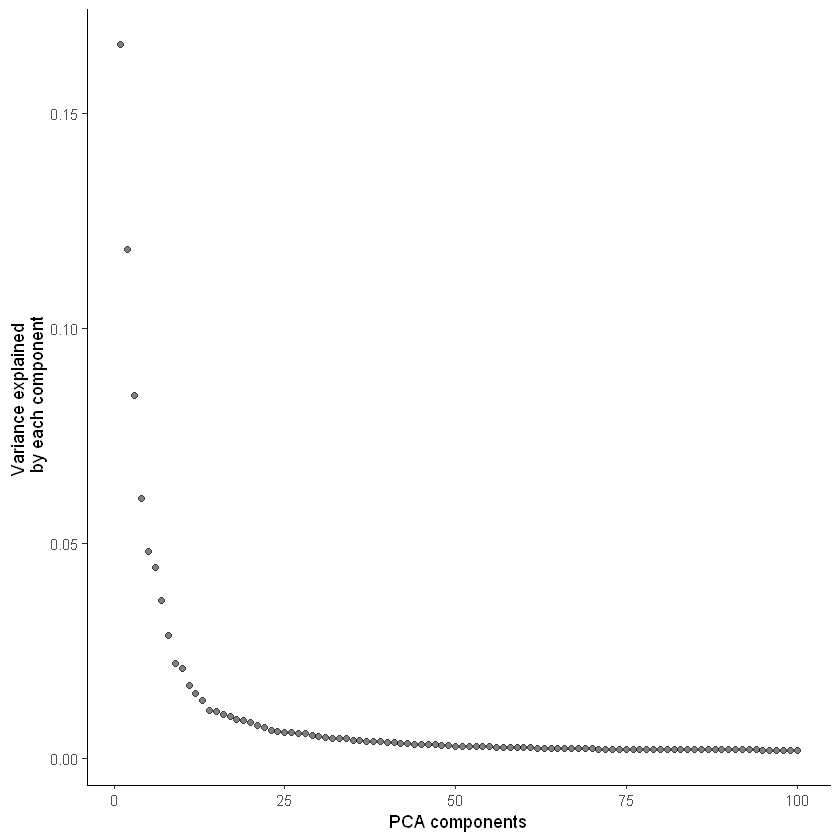

In [7]:


cds<- cds.mouse
# cds <- preprocess_cds(cds, num_dim = 100)
# plot_pc_variance_explained(cds)



# cds <- align_cds(cds, alignment_group = "dataset")
# print('Reducing dimensionality')
# cds <- reduce_dimension(cds)

# print('Clustering cells')
# cds <- cluster_cells(cds)

# cds <- learn_graph(cds)


In [8]:
# saveRDS(cds, 'normalized-cds-saunders-welch-metza.rds')

In [1]:
library(monocle3)


cds = readRDS('normalized-cds-saunders-welch-metza.rds')

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; vie

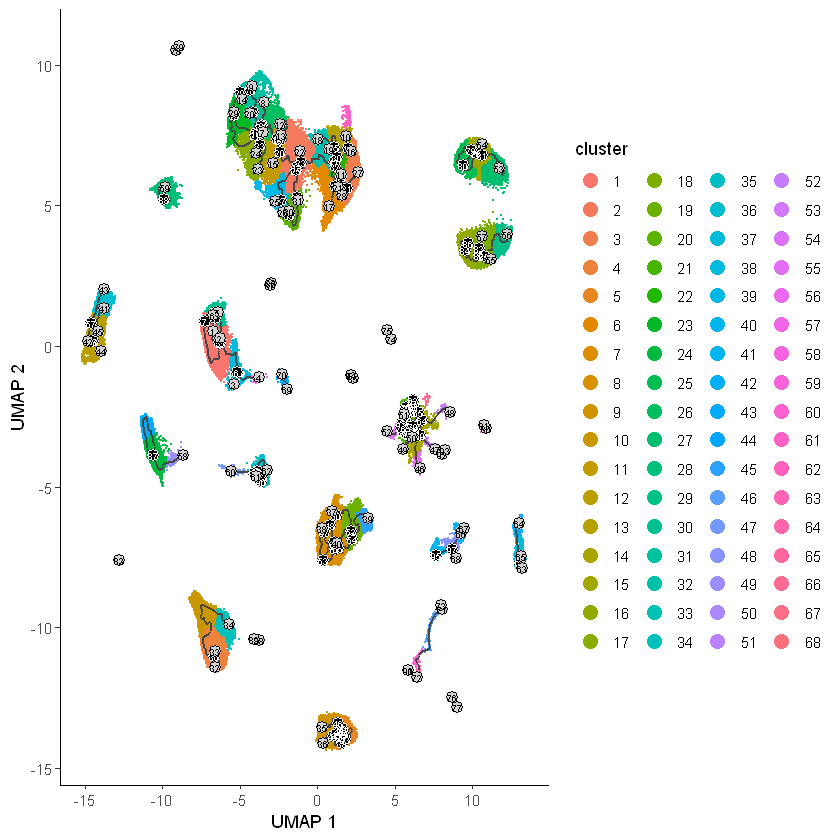

In [17]:
plot_cells(cds, label_cell_groups = FALSE)

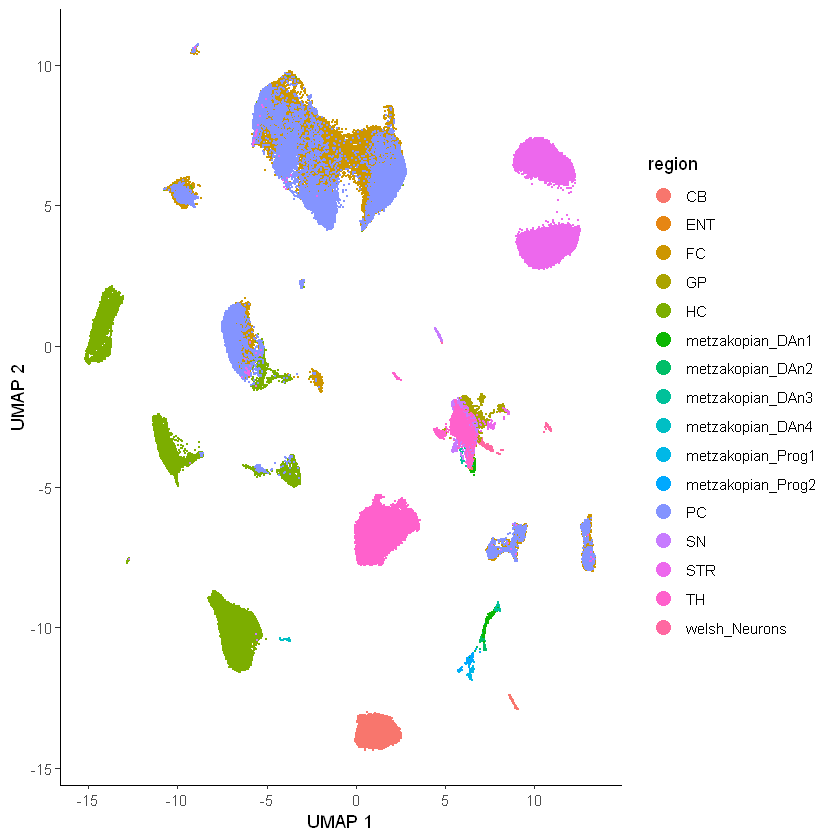

In [13]:
plot_cells(cds, color_cells_by = 'region', label_cell_groups = FALSE, show_trajectory_graph = F)

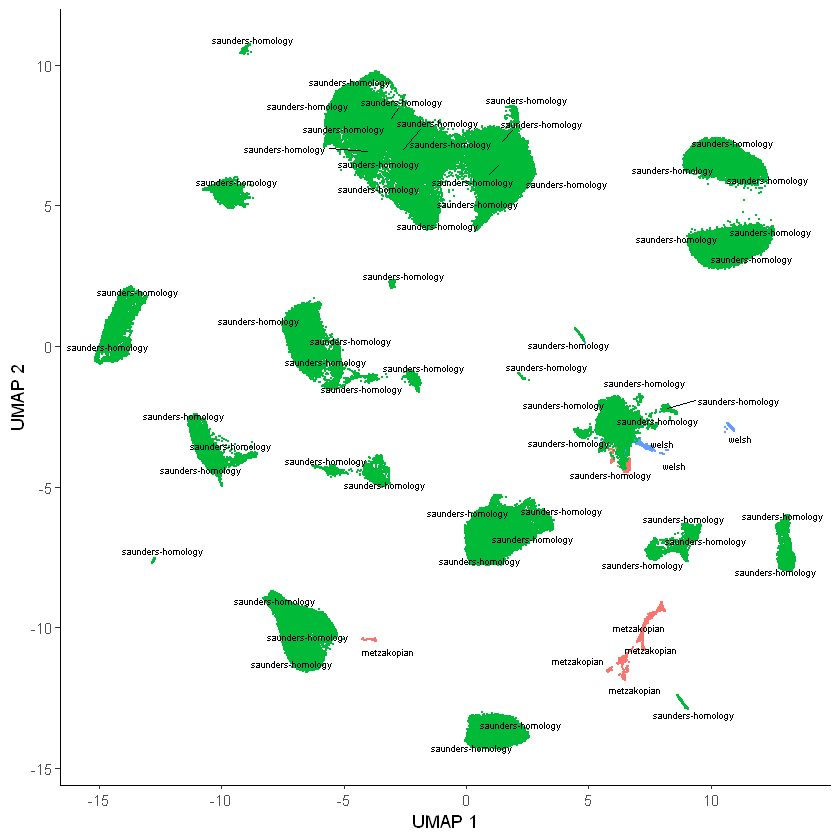

In [2]:
plot_cells(cds, color_cells_by = 'dataset', label_cell_groups = T, show_trajectory_graph = F)



In [ ]:
plot_cells(cds, genes=c('TH','SLC6A3'), label_cell_groups = FALSE, show_trajectory_graph = F)


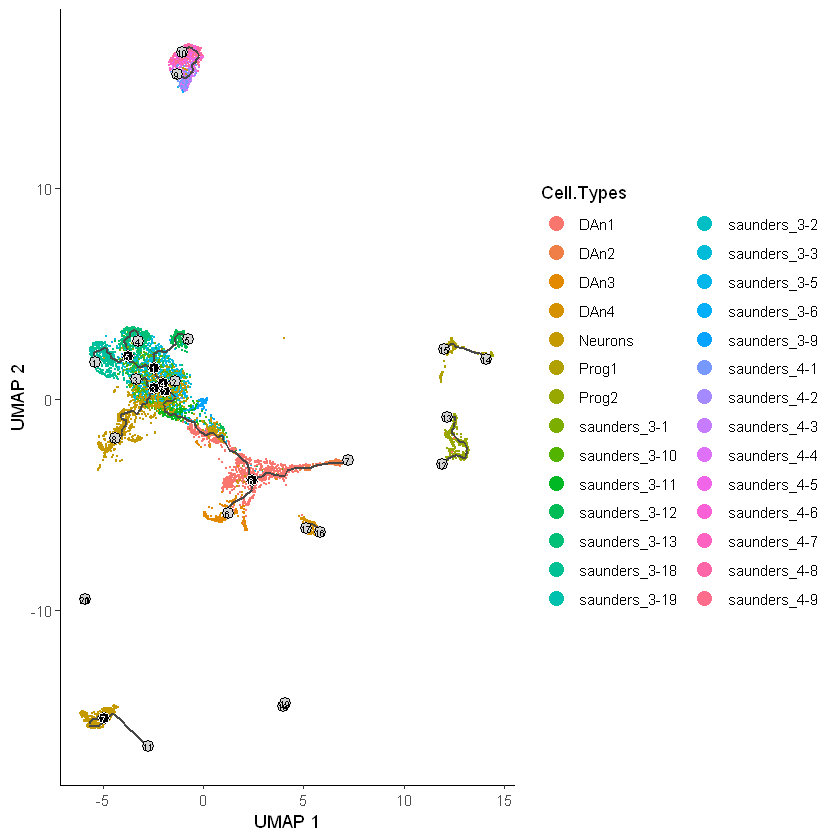

In [286]:
plot_cells(cds, color_cells_by = 'Cell.Types', label_cell_groups = FALSE)

In [18]:
#plot_cells(cds[,clusters(cds) == '1'], color_cells_by = 'Cell.Types',label_cell_groups = FALSE)

saveRDS(cds,'normalized-cds-with-welch.rds')

#clusters(cds) %in%

In [75]:
colData(cds)$clusters = clusters(cds)


df = as.data.frame(colData(cds))
df$region2 = df$region
df$region2[df$dataset == 'metzakopian'] = df$cluster[df$dataset == 'metzakopian']

df$region2[(df$dataset == 'saunders-homology') & (df$region != 'SN')] = 'saunders-other'

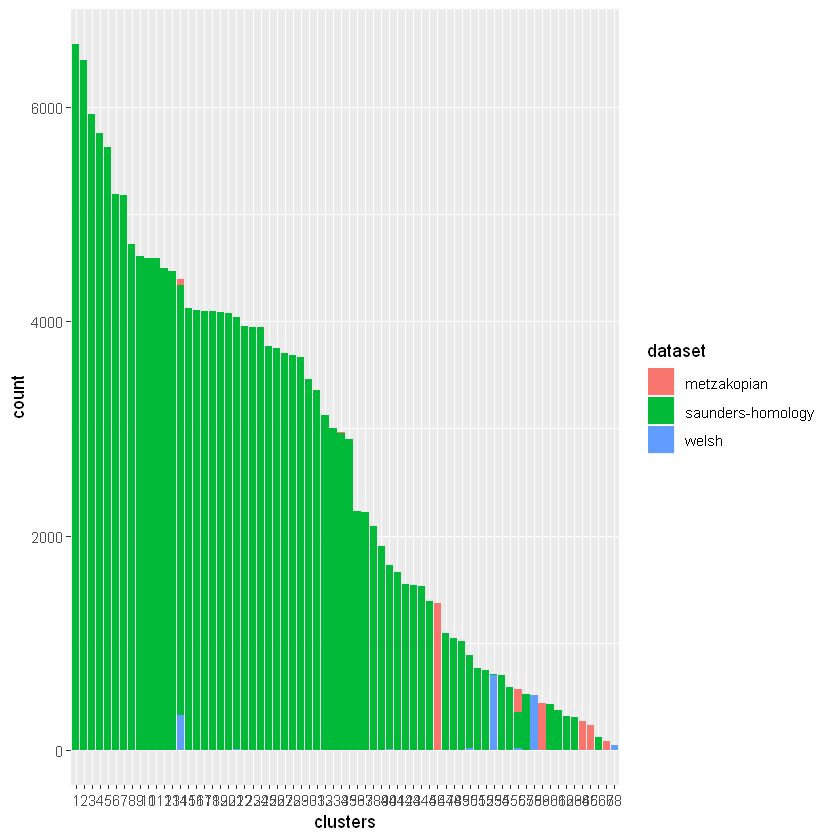

In [46]:
library(ggplot2)

ggplot(data = df, aes(fill = dataset, clusters)) + geom_bar()


In [78]:
library(dplyr)
summary.df = df %>% group_by(region2, clusters) %>% summarise(n = n()) %>%   mutate(freq = n / sum(n))

q = ggplot(data = summary.df, aes(fill = region2, x = clusters, y = freq)) + geom_bar(stat='identity',position="dodge")

ggsave(plot = q, width = 15, height = 6, dpi = 300, filename = "celltype.pdf")

#ggplot(df,aes(clusters, dataset)) + geom_bar()

In [56]:
write.csv(summary.df, 'summary-cluster-overlap.csv')

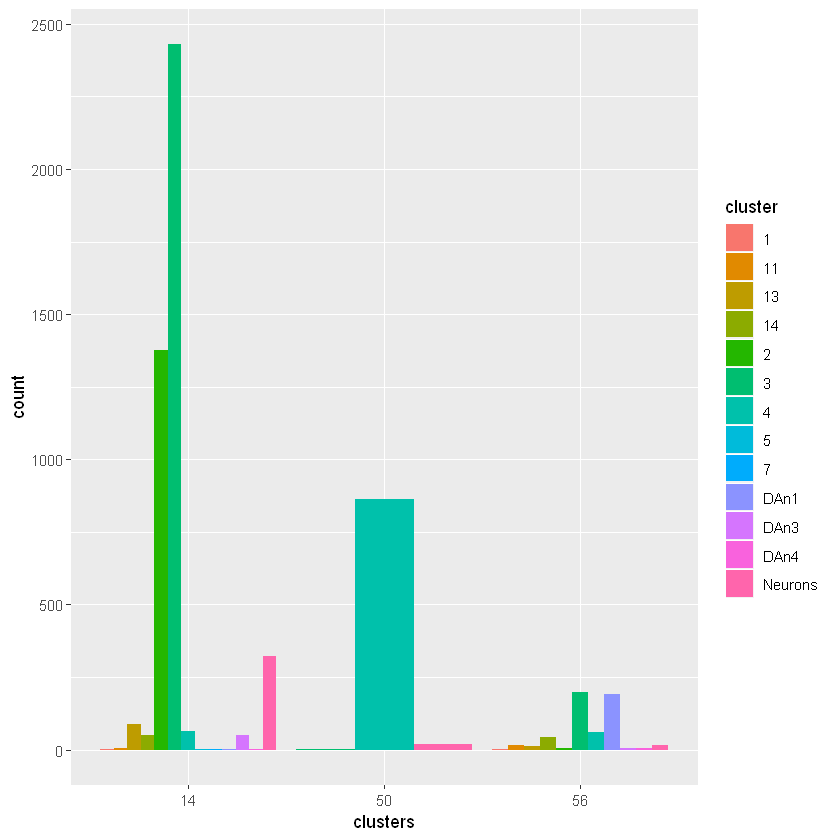

In [77]:



selected = df[df$clusters %in% c('14','56','50'),]

summary.df = selected %>% group_by(cluster, clusters) %>% summarise(n = n()) %>%   mutate(freq = n / sum(n))
q = ggplot(data = selected, aes(fill = cluster, x = clusters)) + geom_bar(position="dodge")
q
